In [641]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from datetime import timedelta
from datetime import datetime
import scipy.stats as stats
import requests as r
import pandas as pd
import numpy as np
import psycopg2
import config
import gmaps
import json
import math

with open('stops_info.json','r') as sf:
    stop_locations = json.load(sf)
    
from IPython.display import display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Query Function for PostgreSQL Communication

In [574]:
def query(Query):
    
    try:

        conn = psycopg2.connect(
            database=config.Database,
            user=config.DBuser,
            password=config.DBpswd,
            
            # Tunneled connection
            host=config.TunnelHost,
            port=config.TunnelPort
            
            # On Eduroam
#             host=config.host,
#             port=config.port
        )
        cursor = conn.cursor()
        
        cursor.execute(Query)
        conn.commit()
        result = cursor.fetchall()
        
        cursor.close()
        conn.close()
        
        return result

    except Exception as e:
        print("Uh oh, can't connect. Invalid dbname, user or password?")
        print(repr(e))

###  Setting up stop locations table, with id and names

In [143]:
pd.DataFrame(stop_locations).to_csv("stop_locations.csv")

## Getting Weather Data From Dark Sky API

In [85]:
def weather_query(timestamp):
    
    request_string = f"https://api.darksky.net/forecast/6d1a9498f039837cce2657a75bd43748/53.3498, -6.2603,{timestamp}?exclude=currently,flags"

    try:
        response = r.get(request_string)
    except Exception as e:
        print(repr(e))
        return False
        
    return json.loads(response.content.decode('utf-8'))

In [86]:
# One year of data starting at time 
start=1514764801
end=1546300801
step=86400

data = {}
count = 0
total = 365
while start < end:
    count += 1
    pct = int(count/total * 100) 
    clear_output(wait=True)
    display(f"Completed: {count}/{total} [{pct}%] <{'=' * int(pct/5)} {' ' * (19 - (int(pct/5) +1))}>")
    data[start] = weather_query(start)
    start += step

'Completed: 365/365 [100%] <==================== >'

In [118]:
hourly_data = {}

data_keys = list(data.keys())

count=1
for j in data_keys:
    for i in range(len(data[j]['hourly']['data'])):
        count += 1
        hourly_data[data[j]['hourly']['data'][i]['time']] = data[j]['hourly']['data'][i].copy()
        # wont work - remeber that dicts are pass by ref

In [120]:
hourly_keys = list(hourly_data.keys())

for hkey in hourly_keys:
    if 'time' in hourly_data[hkey]:
        hourly_data[hkey].pop('time')
    if 'summary' in hourly_data[hkey]:
        hourly_data[hkey].pop('summary')
    if 'windBearing' in hourly_data[hkey]:
        hourly_data[hkey].pop('windBearing')
    if 'precipProbability' in hourly_data[hkey]:    
        hourly_data[hkey].pop('precipProbability')
    if 'apparentTemperature' in hourly_data[hkey]:
        hourly_data[hkey].pop('apparentTemperature')
    if 'dewPoint' in hourly_data[hkey]:
        hourly_data[hkey].pop('dewPoint')
    if 'windGust' in hourly_data[hkey]:
        hourly_data[hkey].pop('windGust')
    if 'uvIndex' in hourly_data[hkey]:    
        hourly_data[hkey].pop('uvIndex')
    if 'precipType' in hourly_data[hkey]:    
        hourly_data[hkey].pop('precipType')
    if 'ozone' in hourly_data[hkey]:    
        hourly_data[hkey].pop('ozone')

In [134]:
df = pd.DataFrame(hourly_data)
df = df.T

df.index = pd.to_datetime(df.index*1000000000)

df.to_csv("weather_darksky.csv")

## Data Analysis

### Initial look at times

In [136]:
trips = query("SELECT * FROM trips;")

In [145]:
trips_df = pd.DataFrame(trips)
trips_df.columns = ['dayofservice', 'tripid', 'lineid', 'routeid', 'direction', 'planned_arr','planned_dep','actual_arr','actual_dep']

In [567]:
# Forward direction 145 routes. All from data. 
trips_145 = trips_df[trips_df.lineid=='145']
trips_145_forward = trips_145[trips_145.direction=="1 "]
trips_145_backwrd = trips_145[trips_145.direction=="2 "]

#trip ids for 145 bus routes in the forward direction.
trips_145_forward_tripids = trips_145_forward.tripid
trips_145_backwrd_tripids = trips_145_backwrd.tripid

In [205]:
full_string = ""

for i in trips_145_forward_tripids[0:1000]:
    full_string += f" tripid='{i}' OR"
    
full_string = "SELECT * FROM leavetimes WHERE " + full_string[:-3] + ";"

In [217]:
ftrips_145_data = {}
temp_data = query(full_string)  

In [218]:
data145 = pd.DataFrame(temp_data)
data145.columns=['date', 'tripid','progrnumber','stoppointid','planned_arr','planned_dep','actual_arr','actual_dep']

(-10, 200)

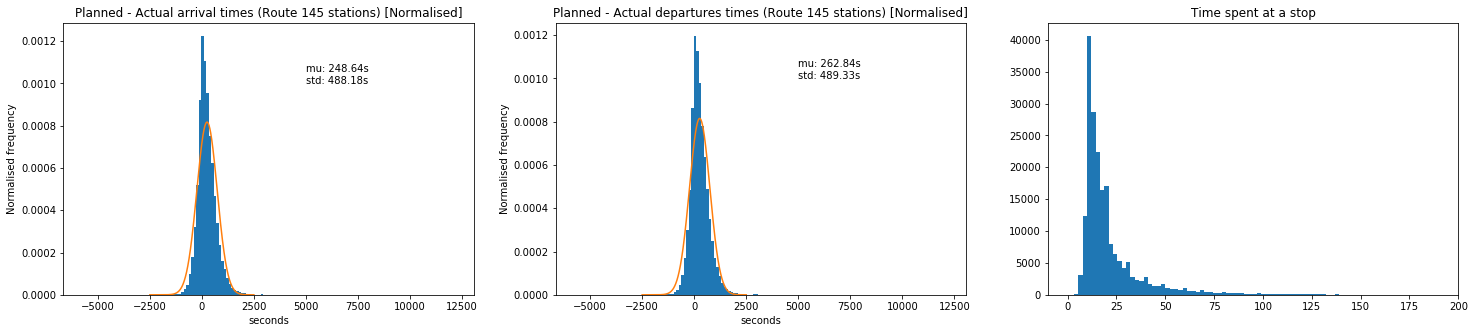

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [816]:
arr_diff = np.array(data145['actual_arr'].astype(float) - data145['planned_arr'].astype(float)) # negative means late
dep_diff = np.array(data145['actual_dep'].astype(float) - data145['planned_dep'].astype(float))
stop_time = list(filter(lambda x: x!=0, dep_diff - arr_diff))


fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,5))
ax1.set_title("Planned - Actual arrival times (Route 145 stations) [Normalised]")
ax1.hist(arr_diff,bins=150,density=True)

# fit gaussian
mu, sigma = stats.norm.fit(arr_diff)
x = np.linspace(-2500, 2500, 1000)
p = stats.norm.pdf(x, mu, sigma)
ax1.plot(x,p)
ax1.set_ylabel('Normalised frequency')
ax1.set_xlabel('seconds')
ax1.text(5000, 0.0010, f"mu: {round(mu,2)}s\nstd: {round(sigma,2)}s")


plt.figure()
ax2.set_title("Planned - Actual departures times (Route 145 stations) [Normalised]")
ax2.hist(dep_diff, bins=150, density=True)

# fit gaussian
mu2, sigma2 = stats.norm.fit(dep_diff)
x2 = np.linspace(-2500, 2500, 1000)
p2 = stats.norm.pdf(x2, mu2, sigma2)
ax2.plot(x2,p2)
ax2.set_ylabel('Normalised frequency')
ax2.set_xlabel('seconds')
ax2.text(5000, 0.0010, f"mu: {round(mu2,2)}s\nstd: {round(sigma2,2)}s")

plt.figure()
ax3.set_title("Time spent at a stop")
ax3.hist(stop_time, bins=1500)
ax3.set_xlim([-10,200])
# ax3.text(2842, 70000, "One point \nout here")

In [316]:
print(f"""
Mean difference between Actual and planned arrival times:   {round(arr_diff.mean(), 2)}s
Mean difference between Actual and planned departure times: {round(dep_diff.mean(), 2)}s
Mean Time spent at a stop: {round(stop_time.mean(), 2)}s
""")


Mean difference between Actual and planned arrival times:   248.64s
Mean difference between Actual and planned departure times: 262.84s
Mean Time spent at a stop: 14.2s



### Looking at the effect of route on time between stops.

In [407]:
leave10 = pd.read_csv('stored_queries\query10.csv', engine='python', header=None)
leave11 = pd.read_csv('stored_queries\query11.csv', engine='python', header=None)
leave10.columns = ['date', 'tripid','progrnumber','stoppointid','planned_arr10','planned_dep10','actual_arr10','actual_dep10']
leave11.columns = ['date', 'tripid','progrnumber','stoppointid','planned_arr11','planned_dep11','actual_arr11','actual_dep11']

In [408]:
print("leave10:",leave10.shape)
print("leave11:",leave11.shape)

leave10: (2098690, 8)
leave11: (2103551, 8)


**Match the tripids and day of service for each column**

In [409]:
# Need to match day and tripid. Then subtract 10 times from 11 times. 
merge1011 = pd.merge(leave10,leave11, on=['date','tripid'])
diff1011 = merge1011.drop(columns=['progrnumber_x','progrnumber_y'])

**Take difference of times**

In [410]:
diff1011['planned_arr_diff'] = diff1011['planned_arr11']-diff1011['planned_arr10']
diff1011['actual_arr_diff'] = diff1011['actual_arr11']-diff1011['actual_arr10']
diff1011['planned_dep_diff'] = diff1011['planned_dep11']-diff1011['planned_dep10']
diff1011['actual_dep_diff'] = diff1011['actual_dep11']-diff1011['actual_dep10']

In [411]:
diff1011.drop(columns=['planned_arr11','planned_arr10','actual_arr10','actual_arr11','planned_dep10','planned_dep11','actual_dep10','actual_dep11'], inplace=True);

**Include the bus number (lineid)**

In [412]:
# trips_df['tripid'] = pd.to_numeric(trips_df['tripid'])
diff1011 = pd.merge(diff1011, trips_df[['lineid','tripid']], on=['tripid'])

**Hypothesis test: Does the lineid matter for time between stops?**

In [502]:
# All bus numbers/ lists
lineids = list(diff1011.lineid.unique())

# for idl in lineids:

tmp = diff1011[diff1011.lineid==lineids[0]].copy()
tmp_uq_stops_pairs = tmp.drop_duplicates(subset=['stoppointid_x','stoppointid_y'])[['stoppointid_x','stoppointid_y']]

uq_stop_pair_tuples = []
for i in tmp_uq_stops_pairs.index:

    uq_stop_pair_tuples.append((tmp_uq_stops_pairs['stoppointid_x'][i], tmp_uq_stops_pairs['stoppointid_y'][i]))

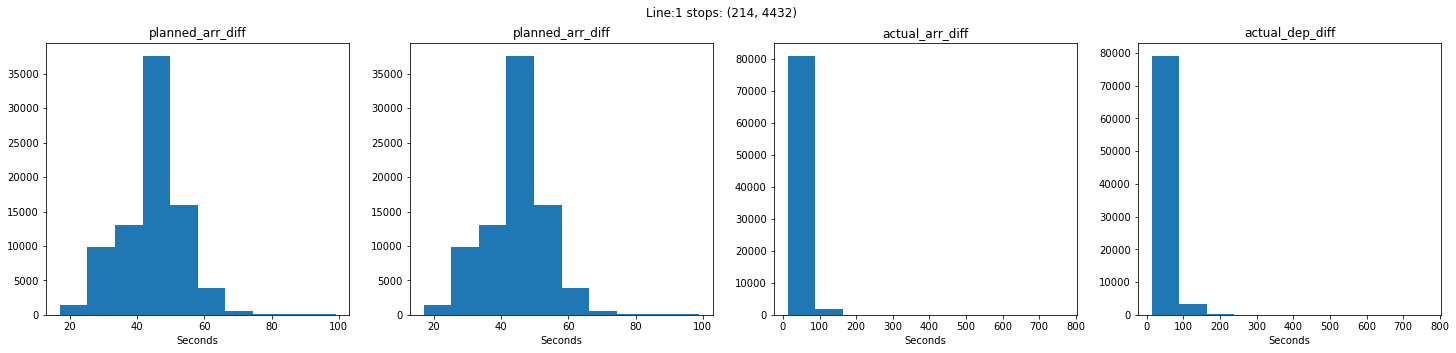

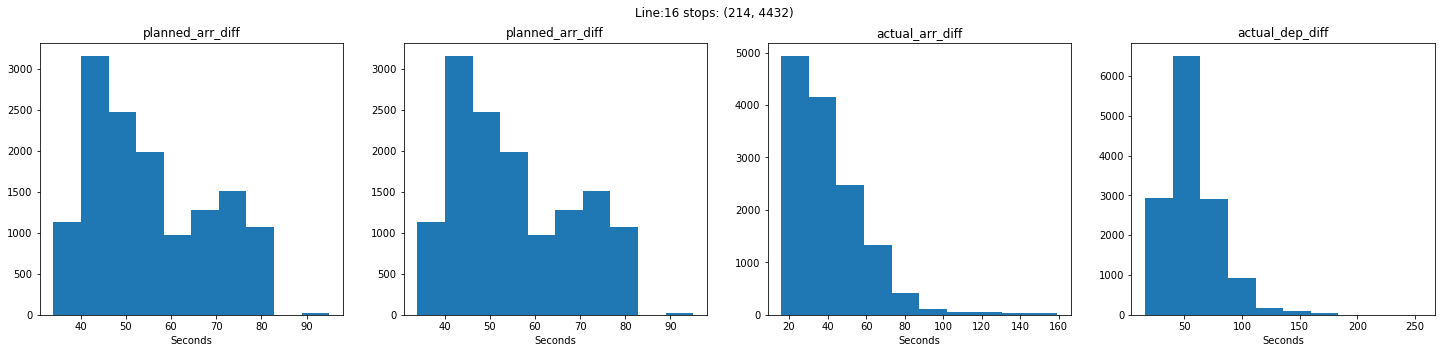

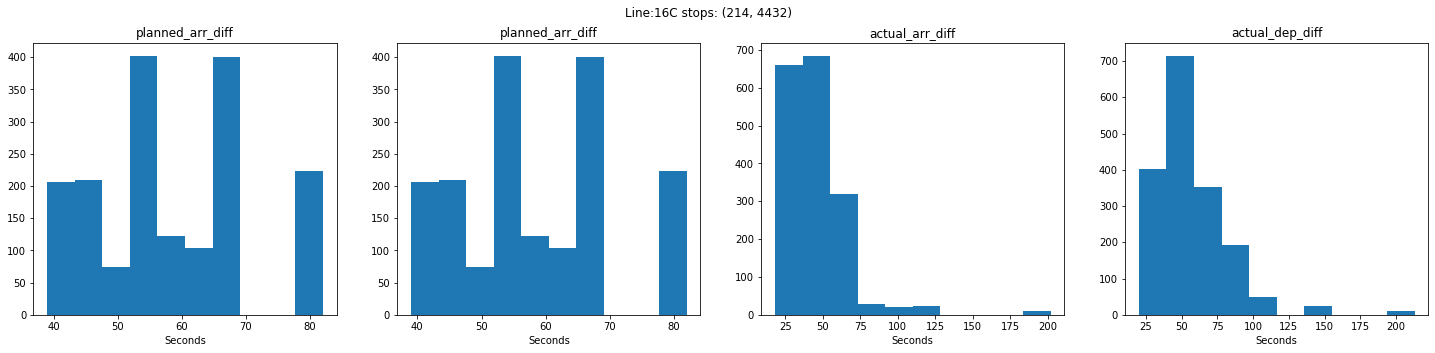

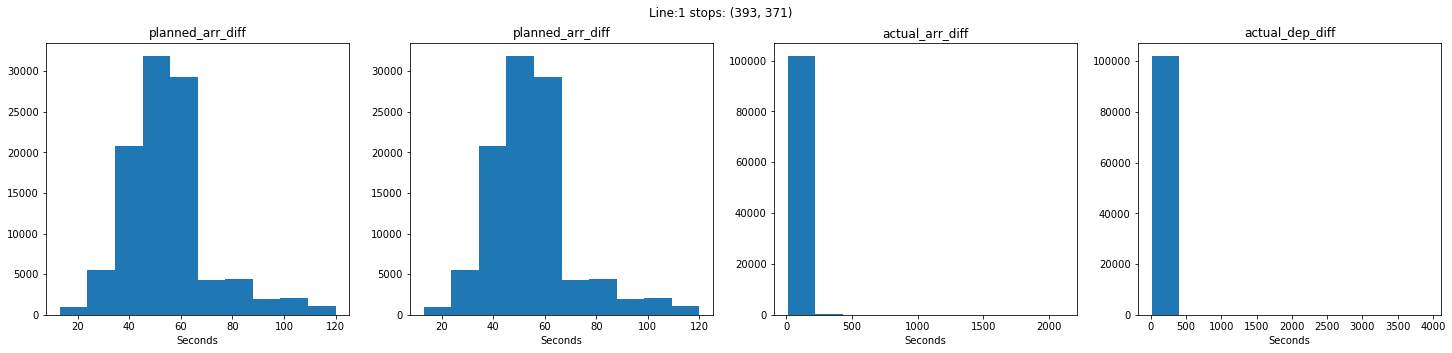

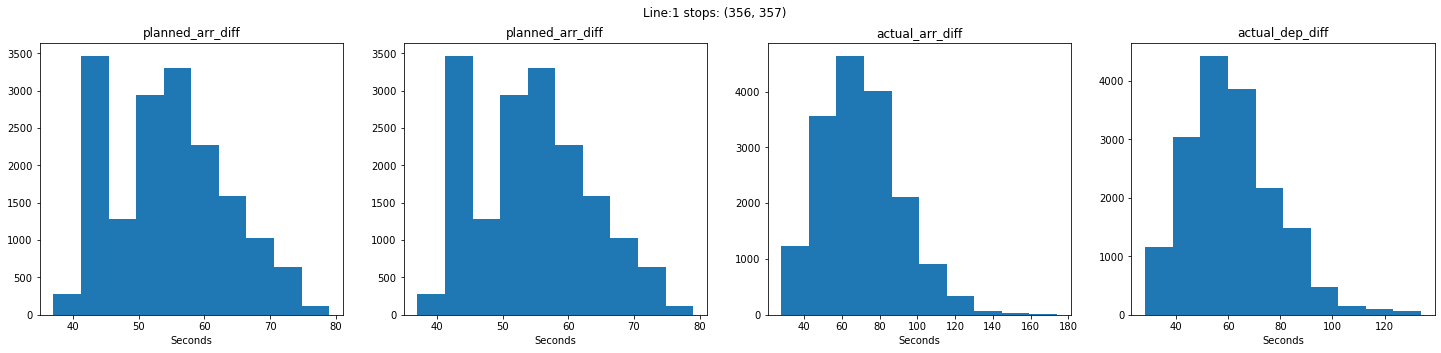

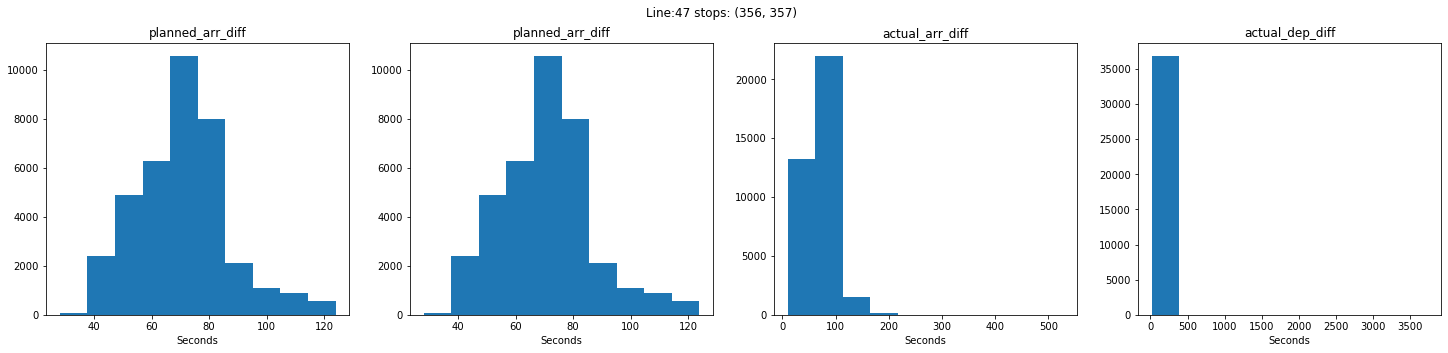

In [561]:
"""
Structure

for each pair:
    
    for each line id:
        
        group the times
        
perform statistical tests on these groupings

"""
for n, pair in enumerate(uq_stop_pair_tuples):
    stop_pair_x = diff1011[diff1011.stoppointid_x==pair[0]]
    stop_pair_ = stop_pair_x[stop_pair_x.stoppointid_y==pair[1]]
    
    for num, lid in enumerate(lineids):
        
        if lid in list(stop_pair_.lineid):
            
            select_lineid = stop_pair_[stop_pair_.lineid==lid]
            
            fig = plt.figure(num+n, figsize=(25,5))
            plt.suptitle(f"Line:{lid} stops: {pair}")
            
            ax1 = fig.add_subplot(1,4,1)
            ax1.set_xlabel('Seconds')
            ax1.set_title("planned_arr_diff")
            ax1.hist(select_lineid.planned_arr_diff)#, bins=20)
        
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_xlabel('Seconds')
            ax2.set_title("planned_arr_diff")
            ax2.hist(select_lineid.planned_dep_diff)#, bins=20)
        
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_xlabel('Seconds')
            ax3.set_title("actual_arr_diff")
            ax3.hist(select_lineid.actual_arr_diff)#, bins=20)
        
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_xlabel('Seconds')
            ax4.set_title("actual_dep_diff")
            ax4.hist(select_lineid.actual_dep_diff)#, bins=20)
        
        else:
            continue
        
    

### Matching weather Data

In [761]:
weatherdf.index.name ="date_recorded"

# total trip lengths
trips_145_match_test = trips_145.copy()

# stop by stop from leavetimes
trips145_times = pd.read_csv("stored_queries/query145leavetimes_full.csv", engine='python', header=None)
# trips145_times.columns=[['dayofservice', 'progrnumber', 'stoppointid', 'actualarr','actualdep', 'plannedarr', 'planneddep']]
trips145_times.columns=[['dayofservice', 'tripid', 'progrnumber', 'stoppointid', 'actualarr','actualdep', 'plannedarr', 'planneddep']]

**Full Journey prediction**

In [762]:
trips_145_forward.head()

,dayofservice,tripid,lineid,routeid,direction,planned_arr,planned_dep,actual_arr,actual_dep
124,2018-03-08,6394314,145,145_104,1,61525,57900,None,None
276,2018-06-06,6859709,145,145_102,1,56753,51600,None,51646
352,2018-08-05,7319855,145,145_102,1,76119,72000,76864,72050
440,2018-06-02,6840310,145,145_102,1,59991,54900,59692,54883
488,2018-08-03,7331783,145,145_102,1,65392,60000,None,None


**RMSE Full Journey Time**

In [806]:
trips_145_FILTERED = trips_145.dropna()

rmse_arrival_full = np.sqrt(metrics.mean_squared_error(trips_145_FILTERED.planned_arr.astype(int), trips_145_FILTERED.actual_arr.astype(int)))
rmse_depart_full  = np.sqrt(metrics.mean_squared_error(trips_145_FILTERED.planned_dep.astype(int), trips_145_FILTERED.actual_dep.astype(int)))

average_trip = (trips_145_FILTERED.actual_arr.astype(int) - trips_145_FILTERED.actual_dep.astype(int)).mean()

print(f"""

Full Trip:
Average Trip length: {round(average_trip,2)}s [{round(average_trip/3600,2)}h]

RMSE Arrival time:   {round(rmse_arrival_full,2)}s  [{round(100*(rmse_arrival_full/average_trip),2)}%] 
RMSE Departure time: {round(rmse_depart_full,2)}s  [{round(100*(rmse_depart_full/average_trip),2)}%]

""")


Full Trip:
Average Trip length: 5178.98s [1.44h]

RMSE Arrival time:   800.87s  [15.46%] 
RMSE Departure time: 222.03s  [4.29%]




**Leavetimes and stops combined predictions**

In [774]:
trips145_times.head()

,dayofservice,tripid,progrnumber,stoppointid,actualarr,actualdep,plannedarr,planneddep
0,2018-01-12,6099784,11,845,60407,60422,60205,60205
1,2018-01-12,6099784,40,3129,62404,62419,62454,62454
2,2018-01-09,6099784,58,4131,63020,63020,63673,63673
3,2018-01-08,6099784,31,2013,61783,61792,61789,61789
4,2018-01-10,6099784,40,3129,62044,62075,62454,62454


**RMSE of planned vs actual predictions from dublin bus between stops**

In [794]:
rmse_arrival = np.sqrt(metrics.mean_squared_error(trips145_times.actualarr, trips145_times.plannedarr))
rmse_depart  = np.sqrt(metrics.mean_squared_error(trips145_times.actualdep, trips145_times.planneddep))
print(f"""
Between Stops:
RMSE Arrival time:   {round(rmse_arrival,2)}s
RMSE Departure time: {round(rmse_depart,2)}s
""")


Between Stops:
RMSE Arrival time:   432.61s
RMSE Departure time: 438.53s



In [754]:
# convert dayofservice to datetime object 
trips145_times['dayofservice'] = pd.to_datetime(trips145_times['dayofservice'].iloc[:,0], format="%Y-%m-%d")

In [755]:
# replace the 
trips145_times['actualarr'] = trips145_times.dayofservice.iloc[:,0] + pd.to_timedelta(trips145_times['actualarr'].iloc[:,0], unit='s')
trips145_times['actualdep'] = trips145_times.dayofservice.iloc[:,0] + pd.to_timedelta(trips145_times['actualdep'].iloc[:,0], unit='s')
trips145_times['plannedarr'] = trips145_times.dayofservice.iloc[:,0] + pd.to_timedelta(trips145_times['plannedarr'].iloc[:,0], unit='s')
trips145_times['planneddep'] = trips145_times.dayofservice.iloc[:,0] + pd.to_timedelta(trips145_times['planneddep'].iloc[:,0], unit='s')

In [756]:
trips145_times.head()

,dayofservice,progrnumber,stoppointid,actualarr,actualdep,plannedarr,planneddep
0,2018-01-10,40,3129,2018-01-10 17:14:04,2018-01-10 17:14:35,2018-01-10 17:20:54,2018-01-10 17:20:54
1,2018-01-10,54,4127,2018-01-10 17:30:47,2018-01-10 17:30:47,2018-01-10 17:34:51,2018-01-10 17:34:51
2,2018-01-10,7,334,2018-01-10 16:30:22,2018-01-10 16:31:09,2018-01-10 16:33:31,2018-01-10 16:33:31
3,2018-01-10,67,4175,2018-01-10 17:46:58,2018-01-10 17:47:13,2018-01-10 17:52:58,2018-01-10 17:52:58
4,2018-01-11,10,842,2018-01-11 16:40:48,2018-01-11 16:42:41,2018-01-11 16:42:06,2018-01-11 16:42:06


In [757]:
# trips145_times.drop(columns='dayofservice')

## Initial Model Training and Testing

### Random Forest Decision Tree training

In [ ]:
RFM = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
RFM.fit(train[predictors], train[target_feature])

RFM_predictions = RFM.predict(train[predictors][:100])